In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import models, Model, layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, minmax_scale
from sklearn.decomposition import PCA
import math
from scipy.interpolate import griddata
from scipy.integrate import cumulative_trapezoid
import seaborn as sns
from matplotlib import cm

In [2]:
'''define parameters here'''
chain_lenght = 21               #spin chain lenght
nodes = [500,200,100]         #network nodes
epochs = 600                    #epochs
batch_size = 100                #batch
outputlayer_shape = 4           #number of parameters to predict
num_of_dcs = 3                  #number of different dcs
num_of_Es = 266                 #number of energies in dI/dV curve
es_dI2d2V = np.linspace(-0.5,4,300)
es_dIdV = np.linspace(0,4,266)
include_gamma = False           #include gamma to the training
d_ind = (1, 0.05)               #dropout layer index and %, no dropout = (0,0)
loss = 'mean_squared_error'     #loss function                                     
n_params = 6                    #number of parameters
SEED = 3                        #random seed for tensorflow
noise_seed = 1                  #random seed for noisy data
include_all = True             #training with all datasets
PCA_noise = 3                   #amount of gaussian noise in PCA fitting
SINUSOIDAL = False              #sinusoidal activation function
RELU = True                     #relu activation function
noise_scaler = 0.01             #noise scaler for noisy copies, DOES NOT CONVERGE FOR 0.1!

tf.config.experimental.enable_op_determinism()        #deterministic in order to repeat results
tf.random.set_seed(SEED)                              #SEED for tensorflow    


In [3]:
def plot_heat(chain_lenght, dcs, es, num_of_dcs, num_of_Es, sample, title:str, norm_max:float, method:str, directions:list):

    '''loop over dynamical correlators'''
    custom_cmap = cm.get_cmap('inferno')  


    for dc in range(num_of_dcs):
        f = open("XYZ.OUT","w")

        '''loop over sites'''
        for s in range(chain_lenght): 
            for idx, freq in enumerate(es):
                D = dcs[sample,(num_of_dcs*s+dc)*num_of_Es:(num_of_dcs*s+dc)*num_of_Es+num_of_Es]
                
                f.write(str(s)+"  ")
                f.write(str(freq)+"  ")
                f.write(str(D[idx])+"\n")

        f.close()

        '''create mesh'''
        x = np.linspace(0,chain_lenght-1,num_of_Es)
        y =  es
        x_mesh, y_mesh = np.meshgrid(x,y)

        d = np.genfromtxt("XYZ.OUT").T
        norm = plt.Normalize(0,norm_max)

        mesh_plot = plt.figure()
        z_mesh = griddata((d[0], d[1]), d[2], (x_mesh, y_mesh), method=method)
        plt.contourf(x_mesh, y_mesh, z_mesh, 100, norm=norm, cmap=custom_cmap)
        plt.tick_params(axis='both', which='major', labelsize=16)
        
        c = plt.colorbar()
        c.ax.tick_params(labelsize=16)


        plt.title(f"{title} {directions[dc]}", fontsize=18)
        plt.xlabel('Site number', fontsize=16)
        plt.ylabel('Energy [E]', fontsize=16)
        plt.savefig(f'spinchain{chain_lenght}_mesh_plot_{dc}_{sample}_{directions[dc]}_.png', dpi=300)
        plt.show()
        

In [4]:
'''download data and split train and test'''
if include_all:
    data10    = np.genfromtxt(f'/Users/35840/Documents/CQM_2024/masters_project/datasets/spinchain21_J2JZJDJ3_10_integrated_GOOD.txt') 
    data911    = np.genfromtxt(f'/Users/35840/Documents/CQM_2024/masters_project/datasets/spinchain21_J2JZJDJ3_911_integrated_GOOD.txt')
    data812    = np.genfromtxt(f'/Users/35840/Documents/CQM_2024/masters_project/datasets/spinchain21_J2JZJDJ3_812_integrated_GOOD.txt')

    '''deleting samples 45 and 238 from sets 10 and 911 since 812 doesn't have them'''
    data10 = np.delete(data10, (45, 238), axis=0)
    data911 = np.delete(data911, (45, 238), axis=0)

    data = np.concatenate((data10[:,0:len(data10[0])-n_params], 
                    data911[:,0:len(data911[0])-n_params], 
                    data812[:,:]), axis=1)
    
else: 
    #data = np.genfromtxt(f'/Users/35840/Documents/CQM_2024/masters_project/datasets/spinchain21_J2JZJDJ3_911_integrated_GOOD.txt')
    data = np.genfromtxt(f'/Users/35840/Documents/CQM_2024/masters_project/datasets/spinchain21_J2JZJDJ3_10_integrated_GOOD.txt')
    data = np.delete(data, (45, 238), axis=0)
    


In [5]:
def compute_cumulative_integral(arr, sites, n_dcs, n_E_final, final_linspace, group_size=300):


    dc_dir_ALL = np.zeros((arr.shape[0],n_E_final*sites*n_dcs))
    
    for sample in range(arr.shape[0]):
        
        chunks = [arr[sample][i:i + group_size] for i in range(0, arr.shape[1], group_size)]
        result = [chunk[(group_size-n_E_final):] for chunk in chunks if len(chunk) >= group_size]
        
        def compute_sum(dI2_d2V, es):
            return cumulative_trapezoid(dI2_d2V, es, initial=0)
        
        dI_dVs = compute_sum(result[:], final_linspace)

        dI_dV  = np.array(np.concatenate(dI_dVs))
        dc_dir_ALL[sample] = dI_dV
        
    return dc_dir_ALL

def include_dc(dcs_all, dc_dir:int, chain_length, n_d, n_E):
    dc_dir_ALL = np.zeros((dcs_all.shape[0], n_E * chain_length))

    for s in range(chain_length):
        start_idx = s * n_d * n_E + dc_dir * n_E
        end_idx = start_idx + n_E
        dc = dcs_all[:, start_idx:end_idx]
        dc_dir_ALL[:, s * n_E:(s + 1) * n_E] = dc

    return dc_dir_ALL

In [6]:
'''drop y direction'''

if include_all:
    dcs_x   = include_dc(data[:, :len(data[0])-n_params], 0, 3*chain_lenght, 3, num_of_Es)
    dcs_z   = include_dc(data[:, :len(data[0])-n_params], 2, 3*chain_lenght, 3, num_of_Es)
    data    = np.concatenate((dcs_x, dcs_z, data[:, len(data[0])-n_params:]), axis = 1)

    train_data                  = data[0:data.shape[0]-data.shape[0]//3, :]
    test_data                   = data[data.shape[0]-data.shape[0]//3:, :]

else:
    dcs_x   = include_dc(data[:, :len(data[0])-n_params], 0, chain_lenght, 3, num_of_Es)
    dcs_z   = include_dc(data[:, :len(data[0])-n_params], 2, chain_lenght, 3, num_of_Es)
    data_    = np.concatenate((dcs_x, dcs_z, data[:, len(data[0])-n_params:]), axis = 1)

    train_data                  = data_[0:data_.shape[0]-data_.shape[0]//3, :]
    test_data                   = data_[data_.shape[0]-data_.shape[0]//3:, :]




In [7]:
def gaussian_noise(x, mu, std, seed):
    if seed != None:
        np.random.seed(seed)
    noise = np.random.normal(mu, std, size = x.shape)
    x_noisy = x + noise
    return x_noisy

def step_noise(x, w):
    dcs_noisy = np.zeros_like(x)
    for s in range(x.shape[0]):
        #print(f'sample {s}')
        for c in range(x.shape[1]):
            dcs_noisy[s,c] = x[s,c] * (1 + w*(np.random.random()-0.5))
    return dcs_noisy

def plot_pca(data):
    pca1 = PCA().fit(data)
    plt.plot(np.cumsum(pca1.explained_variance_ratio_))
    plt.axvline(x = 123, color = 'r', label= '99 % of the explained variance')
    plt.legend()
    plt.axhline(y = 0.99, color = 'r')
    plt.title('Explained variance as a function of PCA components', fontsize = 18)
    plt.xlabel('number of components', fontsize = 15)
    plt.ylabel('cumulative explained variance',fontsize = 15)
    #plt.show()

def noisy_copies(raw_data, n_copies, n_variations, n_params, n_levels, seed):
    noisy_data          = np.tile(raw_data, (n_copies*n_variations,1))
    
    copied_dcs           = np.array(noisy_data[:,0:len(noisy_data[0])-n_params])
    copied_dcs[copied_dcs < 0] = 0
    params               = noisy_data[:,len(noisy_data[0])-n_params:]
    
    for level in n_levels:
        if level == 0:
            continue
        
        s_ind = level*copied_dcs.shape[0]//n_copies
        e_ind = (level+1)*copied_dcs.shape[0]//n_copies
        
        copied_dcs[s_ind:e_ind,:] = gaussian_noise(np.copy(copied_dcs[s_ind:e_ind,:]), mu=0.0, std=level*noise_scaler * np.std(copied_dcs), seed = seed)



    return copied_dcs, params

In [8]:
print(train_data.shape)
print(test_data.shape)

(280, 33522)
(140, 33522)


In [9]:
'''generate noisy training set'''
noise_levels                = [level for level in range(11)]
dcs_train, params_train     = noisy_copies(train_data, 11, 1, 6, noise_levels, seed=noise_seed)
dcs_train[dcs_train < 0]    = 0


In [10]:

'''fit PCA on noisy (chi=0.03) data'''
pca = PCA(0.99)
dcs_for_PCA = dcs_train[PCA_noise*280:(PCA_noise+1)*280,:]
pca.fit(np.array(dcs_for_PCA))

dcs_train                   = np.array(dcs_train)
dcs_train_arr               = pca.transform(dcs_train)

J1_train      = params_train[:,0]
J2_train      = params_train[:,1] 
JZ_train      = params_train[:,2]
JD_train      = params_train[:,3]
J2Z_train     = params_train[:,4]
gamma_train   = params_train[:,5]

dcs_test                    = test_data[:,0:len(test_data[0])-n_params]
dcs_test[dcs_test < 0]      = 0

dcs_test                    = np.array(dcs_test)
dcs_test_arr                = pca.transform(dcs_test)
params_test                 = test_data[:,len(test_data[0])-n_params:]

J1_test      = params_test[:,0]
J2_test      = params_test[:,1] 
JZ_test      = params_test[:,2]
JD_test      = params_test[:,3]
J2Z_test     = params_test[:,4]
gamma_test   = params_test[:,5]


In [11]:
print(dcs_test_arr.shape)
print(dcs_train_arr.shape)

(140, 124)
(3080, 124)


In [12]:
'''define scalers'''
scaler_J2   = MinMaxScaler(feature_range=(0,1)) 
scaler_JZZ  = MinMaxScaler(feature_range=(0,1))
scaler_J2ZZ = MinMaxScaler(feature_range=(0,1))
scaler_JD   = MinMaxScaler(feature_range=(0,1))

'''scale train params'''
J2_train          = np.array(J2_train).reshape(-1,1)
JZ_train          = np.array(JZ_train).reshape(-1,1)
JD_train          = np.array(JD_train).reshape(-1,1)
J2Z_train         = np.array(J2Z_train).reshape(-1,1)

'''scale test params'''
J2_test          = np.array(J2_test).reshape(-1,1)
JZ_test          = np.array(JZ_test).reshape(-1,1)
JD_test          = np.array(JD_test).reshape(-1,1)
J2Z_test         = np.array(J2Z_test).reshape(-1,1)

scaler_J2.fit(np.concatenate((J2_train, J2_test), axis = 0))
scaler_JZZ.fit(np.concatenate((JZ_train, JZ_test), axis = 0))
scaler_J2ZZ.fit(np.concatenate((J2Z_train, J2Z_test), axis = 0))
scaler_JD.fit(np.concatenate((JD_train, JD_test), axis = 0))

J2_scaled_train   = scaler_J2.transform(J2_train)
JZ_scaled_train   = scaler_JZZ.transform(JZ_train)
J2Z_scaled_train  = scaler_J2ZZ.transform(J2Z_train)
JD_scaled_train   = scaler_JD.transform(JD_train)

J2_scaled_test   = scaler_J2.transform(J2_test)
JZ_scaled_test   = scaler_JZZ.transform(JZ_test)
J2Z_scaled_test  = scaler_J2ZZ.transform(J2Z_test)
JD_scaled_test   = scaler_JD.transform(JD_test)



In [13]:
'''apply pca on test set'''
dcs_PCA_train   = np.copy(dcs_train_arr)
dcs_PCA_test    = np.copy(dcs_test_arr)
pca_components  = dcs_PCA_train.shape[1]

print(f"number of PCA components used: {pca_components}")

number of PCA components used: 124


In [14]:
def sinusoidal(x):
    return tf.sin(x)

def piecewise_loss(y_true, y_pred):
    y_true_1, y_true_2, y_true_3, y_true_4 = tf.split(y_true, num_or_size_splits=4, axis=1)
    y_pred_1, y_pred_2, y_pred_3, y_pred_4 = tf.split(y_pred, num_or_size_splits=4, axis=1)
    
    loss_1 = K.mean(K.square(y_true_1 - y_pred_1))
    loss_2 = K.mean(K.square(y_true_2 - y_pred_2))
    loss_4 = K.mean(K.square(y_true_4 - y_pred_4))

    print(f'{loss_1.shape=}')
    print(f'{loss_1=}')
    alpha = 10

    mask_low = tf.cast(tf.less_equal(y_true_3, 0.05), dtype=tf.float32)
    mask_high = tf.cast(tf.greater(y_true_3, 0.05), dtype=tf.float32)

    loss_low = K.mean(alpha*(tf.abs(mask_low*(y_true_3-y_pred_3))))
    loss_high = K.mean(K.square((mask_high*(y_true_3-y_pred_3))))

    loss_3 = loss_low + loss_high

    # Combine the losses
    total_loss = loss_3 + loss_2 + loss_1 + loss_4
    print(f'{total_loss.shape=}')
    print(f'{total_loss=}')
    return total_loss

def custom_loss(y_true, y_pred):
    #MSE
    base_loss = K.mean(K.square(y_true - y_pred))
    print(base_loss)
    #penalty
    factor = 0   #factor because small negatives                                   
    penalty = factor*K.mean(K.maximum(-y_pred, 0.0))

    total_loss = base_loss + penalty

    return total_loss

def baseline_model(list :list, input_shape, output_shape, d_ind, loss):
    model = Sequential()
    '''loop over nodes in the list'''
    for idx, node in enumerate(list):

        if idx == 0:
            if RELU:
                model.add(Dense(node, input_shape=input_shape, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED) , activation='relu'))
                continue
            elif SINUSOIDAL:
                model.add(Dense(node, input_shape=input_shape, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)))
                model.add(Lambda(sinusoidal))
                continue

        '''adding dropout layer before dense layer (number idx)'''
        if idx == d_ind[0] and idx != 0:
            model.add(Dropout(rate=d_ind[1], noise_shape=None, seed=None))

        if RELU:
            model.add(Dense(node, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED), activation='relu'))
        elif SINUSOIDAL:
            model.add(Dense(node, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)))
            model.add(Lambda(sinusoidal))

    if RELU:
        model.add(Dense(output_shape, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED), activation= 'relu'))
    elif SINUSOIDAL:
        model.add(Dense(output_shape, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)))
        model.add(Lambda(sinusoidal))

    model.compile(loss=loss, optimizer='adam', metrics=["accuracy"])
    return model 

def plot_loss(history,name, log):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    if log == True:
        plt.yscale('log')
    plt.title('Loss errors as functions of epochs',fontsize=18)
    plt.xlabel('Epoch',fontsize=18)
    plt.ylabel('Error',fontsize=18)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.savefig(f'{name}_loss', dpi = 300)
    plt.show()


def fit_and_evaluate(nodes, epochs, batch_size, X_test_scaled, y_test_scaled, X_train_scaled, y_train_scaled, input_shape, output_shape, d_ind, loss, name, log:bool):
    NN_model = baseline_model(nodes, input_shape, output_shape, d_ind, loss)
    history = NN_model.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.1)
    print(history.history.keys()) 
    #dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
    results = NN_model.evaluate(X_test_scaled, y_test_scaled)
    print("test loss, test acc:", results)
    NN_model.save(f'{name}.h5')

    plot_loss(history,name,log)

    J_predicted = NN_model.predict(X_test_scaled)
    J_predicted_training = NN_model.predict(X_train_scaled)

    return J_predicted, J_predicted_training

def MSE(true,pred,param='none'):
    MSE = mean_squared_error(y_true=true, y_pred=pred)
    #print(f"{MSE} MSE error of {param}")
    return float(format(MSE, ".4f"))

def MAE(true,pred,param='none'):
    MAE = mean_absolute_error(y_true=true, y_pred=pred)
    #print(f"{MAE} MAE error of {param}")
    return float(format(MAE, ".4f"))

def plot_dc(chain_length, dc, n_d, es):
    name = f"chainlenght_{chain_length}"
    fig, axes = plt.subplots(nrows=math.ceil(chain_length/4), ncols=4, figsize=(5,5))
    axes = axes.flatten()

    for s in range(chain_length):
        for i, color in enumerate(['blue', 'green', 'red'][:n_d]):

            start_idx = (n_d * s + i) * es.shape[0]
            axes[s].plot(es, dc[start_idx:start_idx + es.shape[0]], c=color)
            #axes[s].title.set_text(f"dynamical correlators at site {s}")
            axes[s].set_xlabel('Energy [E], [w]')
            axes[s].set_ylabel('A(w,s) [A]')
            #axes[s].legend()
            axes[s].set_ylim(-0.1, 1.5)

    
    fig.suptitle(f'Dynamical correlators with chainlenght {chain_length}')
    fig.tight_layout()
    plt.legend()
    plt.savefig(f'dc'+name+'.png')
    plt.show()


def compute_fidelity(true:np.array, pred:np.array):

    E_pred_true    = np.mean(np.multiply(pred, true))
    E_pred         = np.mean(pred)
    E_true         = np.mean(true)
    E_pred2        = np.mean(np.multiply(pred, pred))
    E_true2        = np.mean(np.multiply(true, true))
    
    fidelity       = abs(E_pred_true - E_pred*E_true) / math.sqrt((E_true2 - E_true**2)*(E_pred2 - E_pred**2))
    return float(format(fidelity, ".4f"))


In [15]:
network = f'{noise_seed}_{SEED}'
name = f'{nodes}_{epochs}_{pca_components}_{network}_FREDO'
print(f"train size {dcs_PCA_train.shape}, test shape {dcs_PCA_test.shape}")

inputlayer_shape    = (pca_components,)
X_train_scaled      = dcs_PCA_train
X_test_scaled       = dcs_PCA_test

y_train_scaled      = np.concatenate((J2_scaled_train, JZ_scaled_train, JD_scaled_train, J2Z_scaled_train), axis=1)
y_test_scaled       = np.concatenate((J2_scaled_test, JZ_scaled_test, JD_scaled_test, J2Z_scaled_test), axis=1)


train size (3080, 124), test shape (140, 124)


Epoch 1/600
28/28 [==============================] - 1s 16ms/step - loss: 0.0550 - accuracy: 0.7006 - val_loss: 0.0095 - val_accuracy: 0.8214
Epoch 2/600
28/28 [==============================] - 0s 5ms/step - loss: 0.0056 - accuracy: 0.8737 - val_loss: 0.0017 - val_accuracy: 0.9253
Epoch 3/600
28/28 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.9177 - val_loss: 9.9172e-04 - val_accuracy: 0.9481
Epoch 4/600
28/28 [==============================] - 0s 5ms/step - loss: 0.0014 - accuracy: 0.9333 - val_loss: 8.6884e-04 - val_accuracy: 0.9675
Epoch 5/600
28/28 [==============================] - 0s 6ms/step - loss: 0.0012 - accuracy: 0.9484 - val_loss: 7.7855e-04 - val_accuracy: 0.9578
Epoch 6/600
28/28 [==============================] - 0s 5ms/step - loss: 0.0011 - accuracy: 0.9499 - val_loss: 6.6376e-04 - val_accuracy: 0.9513
Epoch 7/600
28/28 [==============================] - 0s 5ms/step - loss: 0.0010 - accuracy: 0.9484 - val_loss: 5.3509e-04 - val_accuracy:

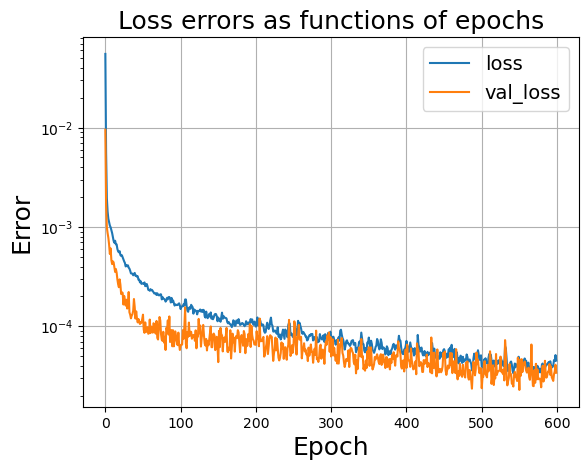

97/97 [==============================] - 0s 2ms/step


In [16]:
'''fit and evaluate the model'''
J_predicted, J_predicted_training = fit_and_evaluate(nodes, epochs, batch_size, X_test_scaled, y_test_scaled, X_train_scaled, y_train_scaled, inputlayer_shape, outputlayer_shape, d_ind, loss, name, True)

In [17]:
'''MSE and MAE of predictions'''
print(MSE(J2_scaled_test, J_predicted[:,0:1], 'test J2'))
print(MSE(J2_scaled_train, J_predicted_training[:,0:1], 'train J2'))
print(MAE(J2_scaled_test, J_predicted[:,0:1], 'test J2'))
print(MAE(J2_scaled_train, J_predicted_training[:,0:1], 'train J2'))

print(MSE(JZ_scaled_test, J_predicted[:,1:2], 'test JZZ'))
print(MSE(JZ_scaled_train, J_predicted_training[:,1:2], 'train JZZ'))
print(MAE(JZ_scaled_test, J_predicted[:,1:2], 'test JZZ'))
print(MAE(JZ_scaled_train, J_predicted_training[:,1:2], 'train JZZ'))

print(MSE(JD_scaled_test, J_predicted[:,2:3], 'test JD'))
print(MSE(JD_scaled_train, J_predicted_training[:,2:3], 'train JDMI'))
print(MAE(JD_scaled_test, J_predicted[:,2:3], 'test JD'))
print(MAE(JD_scaled_train, J_predicted_training[:,2:3], 'train JDMI'))

print(MSE(J2Z_scaled_test, J_predicted[:,3:4], 'test J3'))
print(MSE(J2Z_scaled_train, J_predicted_training[:,3:4], 'train J3'))
print(MAE(J2Z_scaled_test, J_predicted[:,3:4], 'test J3'))
print(MAE(J2Z_scaled_train, J_predicted_training[:,3:4], 'train J3'))


0.001
0.0
0.0221
0.0034
0.0008
0.0
0.0223
0.0041
0.0079
0.0
0.0535
0.0042
0.0014
0.0
0.028
0.0046


In [18]:
'''scale back to original range'''
J2_predicted_inverse_scaled     = scaler_J2.inverse_transform(J_predicted[:,0:1])
JZ_predicted_inverse_scaled    = scaler_JZZ.inverse_transform(J_predicted[:,1:2])
JD_predicted_inverse_scaled     = scaler_JD.inverse_transform(J_predicted[:,2:3])
J2Z_predicted_inverse_scaled   = scaler_J2ZZ.inverse_transform(J_predicted[:,3:4])

J2_predicted_training_scaled    = scaler_J2.inverse_transform(J_predicted_training[:,0:1])
JZ_predicted_training_scaled   = scaler_JZZ.inverse_transform(J_predicted_training[:,1:2])
JD_predicted_training_scaled    = scaler_JD.inverse_transform(J_predicted_training[:,2:3])
J2Z_predicted_training_scaled  = scaler_J2ZZ.inverse_transform(J_predicted_training[:,3:4])

J2_test     = scaler_J2.inverse_transform(J2_scaled_test)
JZ_test     = scaler_JZZ.inverse_transform(JZ_scaled_test)
JD_test     = scaler_JD.inverse_transform(JD_scaled_test)
J2Z_test    = scaler_J2ZZ.inverse_transform(J2Z_scaled_test)
J2_train    = scaler_J2.inverse_transform(J2_scaled_train)
JZ_train    = scaler_JZZ.inverse_transform(JZ_scaled_train)
JD_train    = scaler_JD.inverse_transform(JD_scaled_train)
J2Z_train   = scaler_J2ZZ.inverse_transform(J2Z_scaled_train)


In [19]:

def plot_baselines(baselines, name, chi):
    fig, axes = plt.subplots(nrows=2, ncols=len(baselines)//2, figsize = (10,5))
    axes = axes.flatten()

    for idx, pred in enumerate(baselines):
        axes[idx].scatter(pred[1], pred[2], c = 'blue')
        axes[idx].set_xlabel(f'True {pred[0]} [J]', fontsize=14)
        axes[idx].set_ylabel(f'Predicted {pred[0]} [J]', fontsize = 14)
        axes[idx].plot(pred[1], pred[1], color='red')
        fid = compute_fidelity(pred[2], pred[1])
        axes[idx].text(0.25, 0.8, f'Fidelity: {fid}', fontsize= 14, horizontalalignment='center', verticalalignment='center', transform=axes[idx].transAxes)
        axes[idx].legend()
    
    fig.suptitle(rf'Predicted parameter values compared to the true values with $\chi$={chi}', fontsize=18)
    fig.tight_layout()
    plt.savefig(f'baselines'+name+'.png', dpi=300)
    plt.show()


C:\Users\35840\AppData\Local\Temp\ipykernel_31492\2467274134.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[idx].legend()


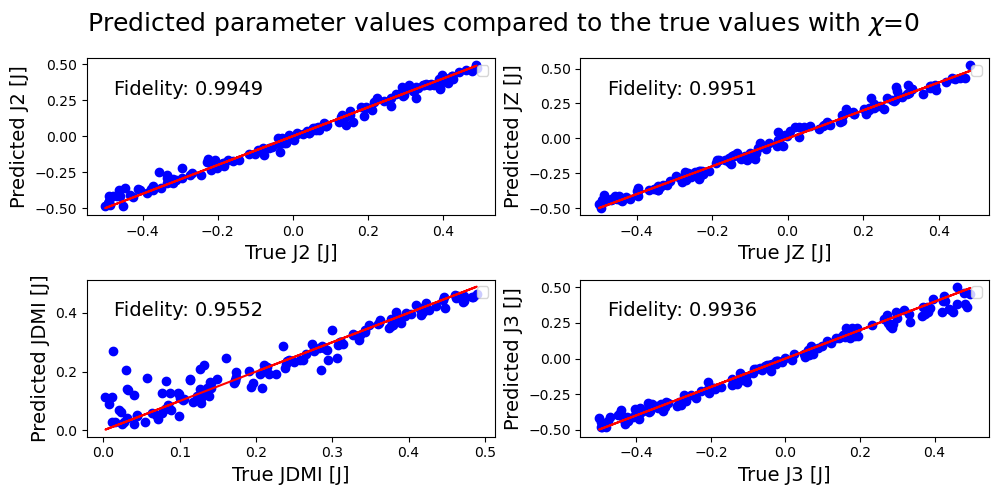

In [20]:

baselines=[('J2', J2_test, J2_predicted_inverse_scaled), 
           ('JZ', JZ_test, JZ_predicted_inverse_scaled), 
           ('JDMI', JD_test, JD_predicted_inverse_scaled), 
           ('J3', J2Z_test, J2Z_predicted_inverse_scaled)]

plot_baselines(baselines=baselines, name=name, chi=0)

predicted_data_save = np.concatenate((J2_predicted_inverse_scaled, JZ_predicted_inverse_scaled, JD_predicted_inverse_scaled, J2Z_predicted_inverse_scaled), axis=1)
np.savetxt('predicted_results_'+name+'.txt', np.array(predicted_data_save))


0.0
5/5 [==============================] - 0s 3ms/step
0.1
5/5 [==============================] - 0s 864us/step
0.2
5/5 [==============================] - 0s 0s/step
0.30000000000000004
5/5 [==============================] - 0s 0s/step
0.4
5/5 [==============================] - 0s 4ms/step
0.5
5/5 [==============================] - 0s 4ms/step
0.6000000000000001
5/5 [==============================] - 0s 0s/step
0.7000000000000001
5/5 [==============================] - 0s 4ms/step
0.8
5/5 [==============================] - 0s 5ms/step
0.9
5/5 [==============================] - 0s 0s/step
1.0
5/5 [==============================] - 0s 0s/step


C:\Users\35840\AppData\Local\Temp\ipykernel_31492\2467274134.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[idx].legend()


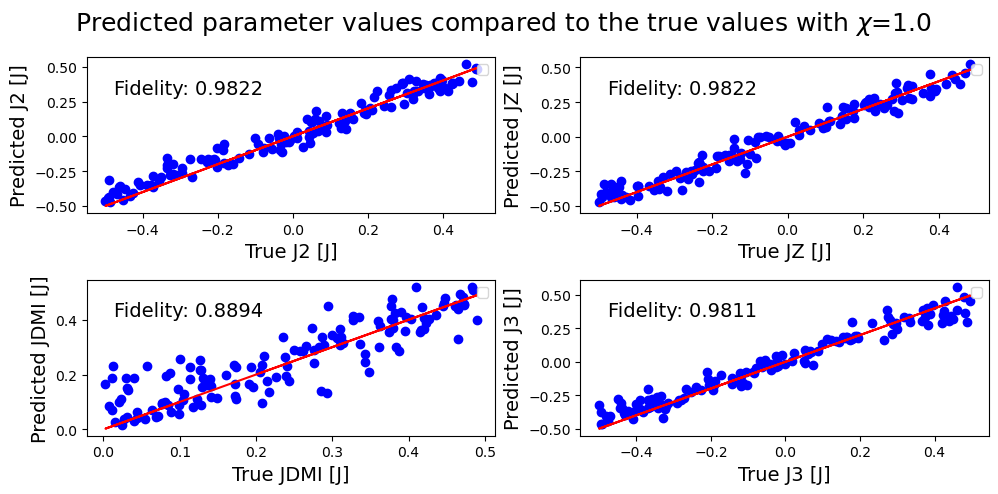

1.1
5/5 [==============================] - 0s 4ms/step
1.2000000000000002
5/5 [==============================] - 0s 0s/step
1.3
5/5 [==============================] - 0s 0s/step
1.4000000000000001
5/5 [==============================] - 0s 805us/step
1.5
5/5 [==============================] - 0s 4ms/step
1.6
5/5 [==============================] - 0s 0s/step
1.7000000000000002
5/5 [==============================] - 0s 4ms/step
1.8
5/5 [==============================] - 0s 4ms/step
1.9000000000000001
5/5 [==============================] - 0s 4ms/step
2.0
5/5 [==============================] - 0s 0s/step
2.1
5/5 [==============================] - 0s 4ms/step
2.2
5/5 [==============================] - 0s 5ms/step
2.3000000000000003
5/5 [==============================] - 0s 4ms/step
2.4000000000000004
5/5 [==============================] - 0s 4ms/step
2.5
5/5 [==============================] - 0s 4ms/step
2.6
5/5 [==============================] - 0s 0s/step
2.7
5/5 [========================

In [21]:
model = tf.keras.models.load_model(f'/Users/35840/Documents/CQM_2024/masters_project/{name}.h5')#,
                                    #custom_objects={'sinusoidal': sinusoidal})#, 'piecewise_loss': piecewise_loss})

def compute_MSE_splits(test, test_params, model_fid, g_range, pca_i):
    # Define ranges and initialize lists for results
    fidelity_results = {'J2': [], 'JZ': [], 'JDM': [], 'J2Z': []}
    error_results    = {'J2': [], 'JZ': [], 'JDM': [], 'J2Z': []}
    g_vals           = []
    g_vals_DMI       = []
    J2_vals          = []
    DMI_vals         = []

    # Inverse transform test parameters
    J2_test = scaler_J2.inverse_transform(test_params[:, 0:1].reshape(-1,1))
    JZ_test = scaler_JZZ.inverse_transform(test_params[:, 1:2].reshape(-1,1))
    JD_test = scaler_JD.inverse_transform(test_params[:, 2:3].reshape(-1,1))
    J2Z_test = scaler_J2ZZ.inverse_transform(test_params[:, 3:4].reshape(-1,1))

    # Function to calculate fidelity and append
    def compute_and_store_fidelity(fids, pred, true, label):
        fids.append(compute_fidelity(true, pred))

    f_MAE = open("MAE_errors_3ImpNet_scaled.txt", "w")
    f_MAE.write("chi & J2 MAE & J3 MAE & JZ MAE & JDMI MAE \n")
    f_MAE.close()

    f_MSE = open("MSE_errors_3ImpNet_scaled.txt", "w")
    f_MSE.write("chi & J2 MSE & J3 MSE & JZ MSE & JDMI MSE \n")
    f_MSE.close()

    f_fid = open("fidelities_3ImpNet_scaled.txt", "w")
    f_fid.write("chi & J2 fidelity & J3 fidelity & JZ fidelity & JDMI fidelity \n")
    f_fid.close()

    # Iterate over the noise range
    for i, g in enumerate(g_range):
        print(g)
        # Add noise and transform
        dcs_gaussian = gaussian_noise(np.copy(test), mu=0.0, std= g * np.std(test), seed=i)

        dcs_test_noisy_transformed = pca_i.transform(dcs_gaussian)
        noisy_results = model_fid.predict(dcs_test_noisy_transformed)

        # Inverse transform predictions
        J2_p_n = scaler_J2.inverse_transform(noisy_results[:, 0:1])
        JZ_p_n = scaler_JZZ.inverse_transform(noisy_results[:, 1:2])
        JD_p_n = scaler_JD.inverse_transform(noisy_results[:, 2:3])
        J2Z_p_n = scaler_J2ZZ.inverse_transform(noisy_results[:, 3:4])

        # Compute and store fidelities and errors
        compute_and_store_fidelity(fidelity_results['J2'], J2_p_n, J2_test, 'J2')
        compute_and_store_fidelity(fidelity_results['JZ'], JZ_p_n, JZ_test, 'JZ')
        compute_and_store_fidelity(fidelity_results['JDM'], JD_p_n, JD_test, 'JDM')
        compute_and_store_fidelity(fidelity_results['J2Z'], J2Z_p_n, J2Z_test, 'J2Z')
        
        if g == 1.0 : 
            baselines=[('J2', J2_test, J2_p_n), ('JZ', JZ_test, JZ_p_n), ('JDMI', JD_test, JD_p_n), ('J3', J2Z_test, J2Z_p_n)]
            plot_baselines(baselines=baselines, name=name, chi=1.0)
            predicted_data_save_ = np.concatenate((J2_p_n, JZ_p_n, JD_p_n, J2Z_p_n), axis=1)
            np.savetxt('predicted_results_NOISE'+name+'.txt', np.array(predicted_data_save_))
            
        f_MAE = open("MAE_errors_3ImpNet_scaled.txt", "a")
        f_MAE.write(f"{g} & {MAE(true=test_params[:, 0:1].reshape(-1,1), pred=noisy_results[:, 0:1])} & {MAE(true=test_params[:, 3:4].reshape(-1,1), pred=noisy_results[:, 3:4])} & {MAE(true=test_params[:, 1:2].reshape(-1,1), pred=noisy_results[:, 1:2])} & {MAE(true=test_params[:, 2:3].reshape(-1,1), pred=noisy_results[:, 2:3])} \n")
        f_MAE.close()

        f_MSE = open("MSE_errors_3ImpNet_scaled.txt", "a")
        f_MSE.write(f"{g} & {MSE(true=test_params[:, 0:1].reshape(-1,1), pred=noisy_results[:, 0:1])} & {MSE(true=test_params[:, 3:4].reshape(-1,1), pred=noisy_results[:, 3:4])} & {MSE(true=test_params[:, 1:2].reshape(-1,1), pred=noisy_results[:, 1:2])} & {MSE(true=test_params[:, 2:3].reshape(-1,1), pred=noisy_results[:, 2:3])} \n")
        f_MSE.close()

        f_fid = open("fidelities_3ImpNet_scaled.txt", "a")
        f_fid.write(f"{g} & {compute_fidelity(test_params[:, 0:1].reshape(-1,1), noisy_results[:, 0:1])} &  {compute_fidelity(true=test_params[:, 3:4].reshape(-1,1), pred=noisy_results[:, 3:4])} & {compute_fidelity(true=test_params[:, 1:2].reshape(-1,1), pred=noisy_results[:, 1:2])} & {compute_fidelity(true=test_params[:, 2:3].reshape(-1,1), pred=noisy_results[:, 2:3])} \n")
        f_fid.close()

    
    return fidelity_results['J2'], fidelity_results['JZ'], fidelity_results['JDM'], fidelity_results['J2Z'], \
           error_results['J2'], error_results['JZ'], error_results['JDM'], error_results['J2Z'], \
           g_vals, g_vals_DMI, J2_vals, DMI_vals


g_range  = np.linspace(0,3,31)


J2_fids, JZ_fids, JDM_fids, J2Z_fids, J2_errors, JZ_errors, JDM_errors, J2Z_errors, g_vals, g_vals_DMI,J2_vals, DMI_vals = compute_MSE_splits(dcs_test, y_test_scaled, model, g_range, pca)


def plot_parameter_heat(baselines, fig_name):
    fig, axes = plt.subplots(nrows=2, ncols=len(baselines)//2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, pred in enumerate(baselines):
        x_mesh, y_mesh = np.meshgrid(np.unique(pred[1]), np.unique(pred[2]))
        z_mesh = griddata((pred[1], pred[2]), pred[3], (x_mesh, y_mesh), method='nearest')

        sns.heatmap(z_mesh, cmap='rainbow', cbar=True, norm=plt.Normalize(-1,10), 
                    cbar_kws={'label': 'MAE %'}, annot=True, ax=axes[idx])

        xtick_labels = np.round(np.unique(pred[4]), 2)
        ytick_labels = np.round(np.unique(pred[2]), 2)

        axes[idx].set_xticks(np.arange(len(xtick_labels)))
        axes[idx].set_xticklabels(xtick_labels)
        axes[idx].set_yticks(np.arange(len(ytick_labels))+1)
        axes[idx].set_yticklabels(ytick_labels)
        axes[idx].invert_yaxis()

        axes[idx].set_title(f'Heatmap of {pred[0]} mean absolute errors')
        axes[idx].set_xlabel(f'{pred[0]} [J]')
        axes[idx].set_ylabel(f'Random Gaussian Noise')


    fig.tight_layout()
    plt.savefig(f'parameterheats'+name+fig_name+'+.png')
    plt.show()



In [ ]:

def plot_fidelity(fidelities, x):
    plt.scatter(x, fidelities[0], color='blue', label='J2')
    plt.scatter(x, fidelities[1], color='green', label='JZ')
    plt.scatter(x, fidelities[2], color='red', label='JDMI')
    plt.scatter(x, fidelities[3], color='orange', label='J3')

    plt.plot(x, fidelities[0], color='blue')
    plt.plot(x, fidelities[1], color='green')
    plt.plot(x, fidelities[2], color='red')
    plt.plot(x, fidelities[3], color='orange')

    plt.title(r'Fidelities as a function of random noise $\chi$', fontsize=18)
    plt.xlabel(r'random noise $\chi$', fontsize=18)    
    plt.ylabel('Fidelity', fontsize=18)
    plt.legend(fontsize=14)
    plt.savefig(f'fidelities'+name+'.png')
    plt.show()

    print([fidelities[0], fidelities[1], fidelities[2], fidelities[3]])

plot_fidelity([J2_fids, JZ_fids, JDM_fids, J2Z_fids], g_range)


In [ ]:

# fidelities_save = np.concatenate(([J2_fids], [JZ_fids], [JDM_fids], [J2Z_fids]), axis = 0)
# fidelities_save_ = np.array(np.concatenate((fidelities_save, [g_range]), axis=0))
# print(fidelities_save_)
# np.savetxt('fidelities'+name+'.txt', np.array(fidelities_save_))


In [ ]:
def compute_noisy_predictions():    
    '''Compute Fidelity of noisy Hamiltonians and plot predictions'''
    noisy_data = np.genfromtxt(f'/Users/35840/Documents/CQM_2024/masters_project/datasets/spinchain21_J2JZJDJ3_J1noisy_integrated_GOOD.txt')

    dcs_x_noisy   = include_dc(noisy_data[:, :len(noisy_data[0])-7], 0, chain_lenght, 3, num_of_Es)
    dcs_z_noisy   = include_dc(noisy_data[:, :len(noisy_data[0])-7], 2, chain_lenght, 3, num_of_Es)
    noisy_data    = np.concatenate((dcs_x_noisy, dcs_z_noisy, noisy_data[:, len(noisy_data[0])-7:]), axis = 1)

    dcs_hn_raw     = noisy_data[:,0:len(noisy_data[0])-7]
    dcs_hn_raw[dcs_hn_raw < 0] = 0
    dcs_hn = dcs_hn_raw
    dcs_hn = np.array(dcs_hn)

    J2_hn      = noisy_data[:,len(noisy_data[0])-6] 
    JZ_hn      = noisy_data[:,len(noisy_data[0])-5]
    JD_hn      = noisy_data[:,len(noisy_data[0])-4]
    J2Z_hn     = noisy_data[:,len(noisy_data[0])-3]

    J2_hn           = np.array(J2_hn).reshape(-1,1)
    JZ_hn           = np.array(JZ_hn).reshape(-1,1)
    JD_hn           = np.array(JD_hn).reshape(-1,1)
    J2Z_hn          = np.array(J2Z_hn).reshape(-1,1)

    J2_test_scaled  = scaler_J2.transform(J2_hn)
    JZ_test_scaled  = scaler_JZZ.transform(JZ_hn)
    JDM_test_scaled = scaler_JD.transform(JD_hn)
    J2Z_test_scaled = scaler_J2ZZ.transform(J2Z_hn)

    '''gaussian noise add'''
    fidelity_results_hn = {'J2': [], 'JZ': [], 'JDM': [], 'J2Z': []}
    def compute_and_store_fidelity(fids, pred, true, label):
        fids.append(compute_fidelity(true, pred))
    
    #pca_i = PCA(n_components=126)
    #dcs_for_PCA = np.concatenate((dcs_hn, dcs_hn, dcs_hn, dcs_hn), axis = 0)
    #print(dcs_for_PCA.shape)
    #pca_i.fit(dcs_for_PCA)
    f_MAE = open("MAE_errors_1ImpNetJ1.txt", "w")
    f_MAE.write("chi & J2 MAE & J3 MAE & JZ MAE & JDMI MAE \n")
    f_MAE.close()

    f_MSE = open("MSE_errors_1ImpNetJ1.txt", "w")
    f_MSE.write("chi & J2 MSE & J3 MSE & JZ MSE & JDMI MSE \n")
    f_MSE.close()

    f_fid = open("fidelities_1ImpNetJ1.txt", "w")
    f_fid.write("chi & J2 fidelity & J3 fidelity & JZ fidelity & JDMI fidelity \n")
    f_fid.close()


    for i, g in enumerate(g_range):
        print(g)
        # Add noise and transform
        dcs_gaussian_hn = gaussian_noise(np.copy(dcs_hn), mu=0.0, std= g * np.std(dcs_hn), seed=i)

        dcs_hn_PCA = pca.transform(dcs_gaussian_hn)
        hn_results = model.predict(dcs_hn_PCA)

        '''scale back to original values'''
        J2_hn_pred     = scaler_J2.inverse_transform(hn_results[:,0:1])
        JZ_hn_pred     = scaler_JZZ.inverse_transform(hn_results[:,1:2])
        JD_hn_pred     = scaler_JD.inverse_transform(hn_results[:,2:3])
        J2Z_hn_pred    = scaler_J2ZZ.inverse_transform(hn_results[:,3:4])

        # Compute and store fidelities
        compute_and_store_fidelity(fidelity_results_hn['J2'], J2_hn_pred, J2_hn, 'J2')
        compute_and_store_fidelity(fidelity_results_hn['JZ'], JZ_hn_pred, JZ_hn, 'JZ')
        compute_and_store_fidelity(fidelity_results_hn['JDM'], JD_hn_pred, JD_hn, 'JDM')
        compute_and_store_fidelity(fidelity_results_hn['J2Z'], J2Z_hn_pred, J2Z_hn, 'J2Z')
        
        print(J2_hn.shape, J2_hn_pred.shape)
        f_MAE = open("MAE_errors_1ImpNetJ1.txt", "a")
        f_MAE.write(f"{g} & {MAE(true=J2_test_scaled, pred=hn_results[:,0:1])} & {MAE(true=J2Z_test_scaled, pred=hn_results[:,3:4])} & {MAE(true=JZ_test_scaled, pred=hn_results[:,1:2])} & {MAE(true=JDM_test_scaled, pred=hn_results[:,2:3])} \n")
        f_MAE.close()

        f_MSE = open("MSE_errors_1ImpNetJ1.txt", "a")
        f_MSE.write(f"{g} & {MSE(true=J2_test_scaled, pred=hn_results[:,0:1])} & {MSE(true=J2Z_test_scaled, pred=hn_results[:,3:4])} & {MSE(true=JZ_test_scaled, pred=hn_results[:,1:2])} & {MSE(true=JDM_test_scaled, pred=hn_results[:,2:3])} \n")
        f_MSE.close()

        f_fid = open("fidelities_1ImpNetJ1.txt", "a")
        f_fid.write(f"{g} & {compute_fidelity(J2_test_scaled, hn_results[:,0:1])} &  {compute_fidelity(J2Z_test_scaled, hn_results[:,3:4])} & {compute_fidelity(JZ_test_scaled, hn_results[:,1:2])} & {compute_fidelity(JDM_test_scaled, hn_results[:,2:3])} \n")
        f_fid.close()

        if g== 0:
            baselines=[('J2', J2_hn, J2_hn_pred), ('JZ', JZ_hn, JZ_hn_pred), 
                    ('JDMI', JD_hn, JD_hn_pred), ('J3', J2Z_hn, J2Z_hn_pred)]
            plot_baselines(baselines=baselines, name='noisy_hamiltonian_baselines_MSE', chi=0.0)
            predicted_data__hn_save = np.concatenate((J2_hn_pred, JZ_hn_pred, JD_hn_pred, J2Z_hn_pred), axis=1)
            np.savetxt('predicted_noisyH_PCA_results_nog_'+name+'.txt', np.array(predicted_data__hn_save))
        if g == 1:
            baselines=[('J2', J2_hn, J2_hn_pred), ('JZ', JZ_hn, JZ_hn_pred), 
                    ('JDMI', JD_hn, JD_hn_pred), ('J3', J2Z_hn, J2Z_hn_pred)]
            plot_baselines(baselines=baselines, name='noisy_hamiltonian_noisy_baselines_MSE', chi=1.0)
            predicted_data__hn_noise_save = np.concatenate((J2_hn_pred, JZ_hn_pred, JD_hn_pred, J2Z_hn_pred), axis=1)
            np.savetxt('predicted_noisyH_PCA_results_'+name+'.txt', np.array(predicted_data__hn_noise_save))
    
    return fidelity_results_hn['J2'], fidelity_results_hn['JZ'], fidelity_results_hn['JDM'], fidelity_results_hn['J2Z']

J2_fids_hn, JZ_fids_hn, JDM_fids_hn, J2Z_fids_hn = compute_noisy_predictions()
plot_fidelity([J2_fids_hn, JZ_fids_hn, JDM_fids_hn, J2Z_fids_hn], g_range)

fidelities_save_hn = np.concatenate(([J2_fids_hn], [JZ_fids_hn], [JDM_fids_hn], [J2Z_fids_hn]), axis = 0)
fidelities_save_hn_ = np.array(np.concatenate((fidelities_save_hn, [g_range]), axis=0))
print(fidelities_save_hn_)
np.savetxt('fidelities_PCA'+name+'.txt', np.array(fidelities_save_hn_))